In [1]:
import rospy
import sensor_msgs.point_cloud2 as pc2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from subprocess import Popen
import sys
sys.path.insert(0, "/home/ankit/rosbag/pyniel") # Pyniel as available on github
from numpy_tools.gridify import gridify
%matplotlib notebook
plt.ion()

global frames
frames = []
MAX_FRAMES = 200

In [2]:
#!/usr/bin/env python
def callback(data):
    global frames
    rospy.loginfo("Frame: %s " +  rospy.get_caller_id() + "I heard %s", len(frames), data.width)
    clear_output(wait=True)
    frames.append(data)
    if len(frames) > MAX_FRAMES:
      rospy.signal_shutdown("Message received")
    
def listener():
    # In ROS, nodes are uniquely named. If two nodes with the same
    # node are launched, the previous one is kicked off. The
    # anonymous=True flag means that rospy will choose a unique
    # name for our 'listener' node so that multiple listeners can
    # run simultaneously.
    rospy.init_node('listener', anonymous=True)

    rospy.Subscriber("/velodyne_points", pc2.PointCloud2, callback)

    # spin() simply keeps python from exiting until this node is stopped
    rospy.spin()

if __name__ == '__main__':
#     pcore = Popen(['roscore'])
#     p = Popen(['rosbag','play','/home/ankit/rosbag/2018-03-06-14-03-06.bag']) # something long running
    listener()
#     p.terminate()
#     pcore.terminate()

[INFO] [1521135887.435534]: Frame: 164 /listener_18983_1521135870604I heard 11822


In [3]:
old_frames = frames

In [4]:
frames = old_frames
frames = [np.array([list(point) for point in pc2.read_points(frame, field_names = None)]) 
          for frame in frames]

In [5]:
# for i in range(len(frames)):
#     print len(frames[i])
print frames[0]
ind = 4
print max(frames[0][:,ind]), min(frames[0][:,ind])

[[ -3.31130195e+00   3.58328409e-02   5.78023717e-02   1.40000000e+01
    8.00000000e+00]
 [ -3.39512849e+00   3.79251540e-02   1.77942261e-01   2.40000000e+01
    9.00000000e+00]
 [ -3.55704236e+00   4.15964015e-02   4.36779767e-01   1.40000000e+01
    1.10000000e+01]
 ..., 
 [ -3.45424652e+00   2.15506718e-01   7.99026191e-01   1.90000000e+01
    1.40000000e+01]
 [ -8.62192035e-01   5.37912287e-02  -1.50788790e-02   3.90000000e+01
    7.00000000e+00]
 [ -3.43969798e+00   2.15202510e-01   9.23466384e-01   1.30000000e+01
    1.50000000e+01]]
15.0 3.0


In [6]:
ind = 4
ring_id = 13
get_rings_0 = frames[0][:,ind]

def get_ring_i(ring_id, scan_id):
    get_rings = frames[scan_id][:,4]
    ring_0 = np.where(get_rings == ring_id)
#     print ring_0
    points_in_ring_0 = frames[scan_id][ring_0, :][0]
#     print points_in_ring_0[:,0:3]
#     print max(points_in_ring_0[:,0]), min(points_in_ring_0[:,0])

    x0 = points_in_ring_0[:,0]
    y0 = points_in_ring_0[:,1]
    z0 = points_in_ring_0[:,2]
    
#     return x, y, z

#     x0, y0, z0 = get_ring_i(0, get_rings)
#     plt.figure()
#     plt.scatter(x0, y0, marker='s', edgecolor="none")


    w0 = np.arctan2(y0, x0)
    r0 = np.sqrt(x0*x0+y0*y0)
    r0_log = np.log10(r0+1)
    
    return x0, y0, z0, w0, r0_log

In [7]:
print len(frames)

165


<IPython.core.display.Javascript object>


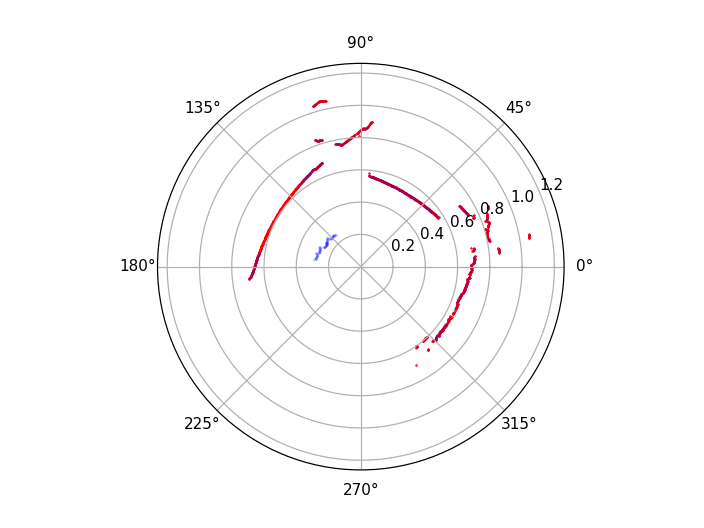

In [19]:
x0, y0, z0, w0, r0_log = get_ring_i(13, 80)
x1, y1, z1, w1, r1_log = get_ring_i(13, 10) #50


fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(w0, r0_log, cmap='hsv', alpha=0.75, s=0.5, marker='x', c='r')
c = ax.scatter(w1, r1_log, cmap='hsv', alpha=0.2, s=0.05, marker='o', c='b')


In [20]:
# # https://gist.github.com/temporaer/6755266
# def plot_logpolar(ax, theta, r_, bullseye=None, **kwargs):
#     min10 = np.log10(np.min(r_))
#     max10 = np.log10(np.max(r_))
#     if bullseye is None:
#         bullseye = min10 - np.log10(0.5 * np.min(r_))
#     r = np.log10(r_) - min10 + bullseye
#     ax.plot(theta, r, **kwargs)
#     l = np.arange(np.floor(min10), max10)
#     ax.set_rticks(l - min10 + bullseye) 
#     ax.set_yticklabels(["1e%d" % x for x in l])
#     ax.set_rlim(0, max10 - min10 + bullseye)
#     ax.set_title('log-polar manual')
#     return ax

# ax = plt.subplots(1, 2, subplot_kw=dict(polar=True))[1].flatten()
# plot_logpolar(ax[0], w0, r0_log)

In [21]:
# assuming 1600 points per ring, 360/1600 = 0.225 degrees
# divide log radius into 1200 parts
# divide ring into worst case horizontal angular resolution = 0.4 degrees
# divide log distance by 0.05
def occupancy(w, r_log):
    oc_grid = np.zeros((901, 200))
    angle_bin = np.rint(w*57.2958/0.4)+450
    distance_bin = np.rint(r_log/0.1)
    
    angle_bin = angle_bin.astype(int)
    distance_bin = distance_bin.astype(int)
#     print angle_bin
#     print distance_bin
    
#     print max(angle_bin), min(angle_bin)
#     print max(distance_bin), min(distance_bin)
    
    oc_grid[angle_bin, distance_bin] += 1
    return oc_grid

oc_grid = occupancy(w0, r0_log)
# print np.where(oc_grid == 1)

# plt.figure()
# plt.hist(np.where(oc_grid != 0)[1])

In [22]:
print "ere"
oc_grid_static = occupancy(w0, r0_log)
oc_grid_smoky = occupancy(w1, r1_log)

ere


In [23]:
def groundtruth_ring(static, smoky):
    gt = smoky - static
    r, c = np.where(gt < 1)
    gt[r, c] = 0
    return gt

def unpack_gt(gt, x_smoky, y_smoky, z_smoky, w_smoky, r_smoky):
    x_gt, y_gt, z_gt, w_gt, r_gt = [], [], [], [], []
    
    angle_bin = np.rint(w_smoky*57.2958/0.4) + 450
    distance_bin = np.rint(r_smoky/0.1)
    
    angle_bin = angle_bin.astype(int)
    distance_bin = distance_bin.astype(int)
    print angle_bin
    print distance_bin
    
    print len(angle_bin), len(distance_bin)
    
    r, c = np.where(gt == 1)
    print r, c
    
    for i in range(len(angle_bin)):
        if angle_bin[i] in r and distance_bin[i] in c:
            x_gt.append(x_smoky[i])
            y_gt.append(y_smoky[i])
            z_gt.append(z_smoky[i])
            w_gt.append(w_smoky[i])
            r_gt.append(r_smoky[i])
    
    return x_gt, y_gt, z_gt, w_gt, r_gt
    

gt_grid = groundtruth_ring(oc_grid_static, oc_grid_smoky)
x_gt, y_gt, z_gt, w_gt, r_gt = unpack_gt(gt_grid, x1, y1, z1, w1, r1_log)
print len(x_gt)
print len(y_gt)
print len(z_gt)
print len(w_gt)
print len(r_gt)

[819 818 818 ..., 812 812 811]
[2 2 3 ..., 3 3 3]
1155 1155
[338 360 367 379 388 421 438 464 464 474 507 512 530 550 645 674 754 771
 772 773 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789
 789 790 791 792 793 794 795 796 797 798 799 800 801 802 803 804 805 806
 807 808 809 810 811 812 813 814 815 816 817 818 818 819 819 820 821 822
 822 823 824 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838
 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856
 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874
 875 876 877 878 879] [7 6 6 6 6 7 7 7 9 7 9 8 7 5 5 8 7 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 2 3 3 3 2 3 2
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
261
261
261
261
261


<IPython.core.display.Javascript object>


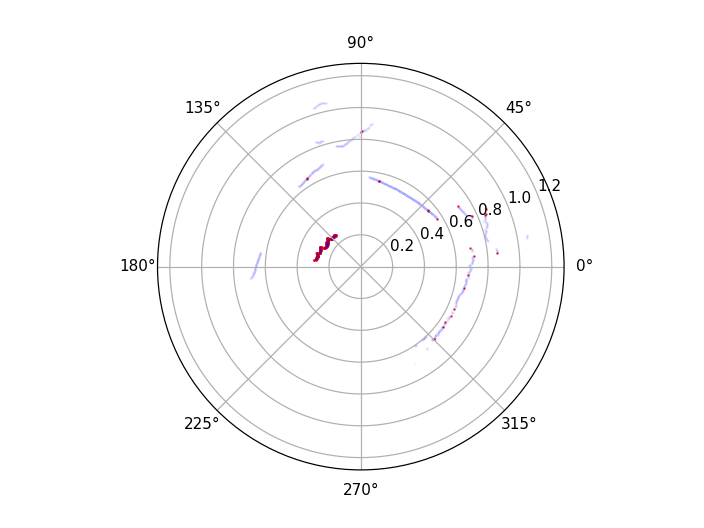

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(w_gt, r_gt, cmap='hsv', alpha=1.0, s=0.2, marker='x', c='r')
c = ax.scatter(w1, r1_log, cmap='hsv', alpha=0.1, s=0.1, marker='o', c='b')

In [173]:
print max(r1_log)-min(r1_log), min(w0)
x = np.array(np.arange(10))
x = np.reshape(x, (2,5))
print x
print np.where(x >=16)

1.1104303706 -3.13862562174
[[0 1 2 3 4]
 [5 6 7 8 9]]
(array([], dtype=int64), array([], dtype=int64))


## Test on single frame

In [4]:
points = frames[0]
x = points[:,0]
y = points[:,1]
z = points[:,2]
w = np.arctan2(y, x)
r = np.sqrt(x*x+y*y)
j = np.arange(x.size)

<IPython.core.display.Javascript object>


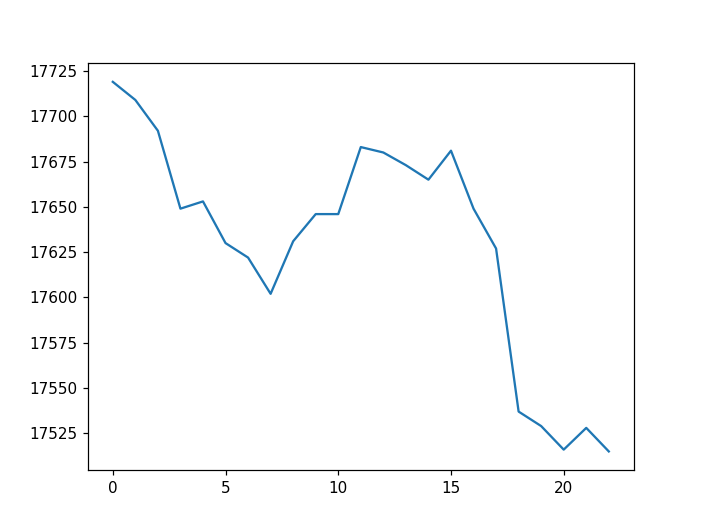

In [5]:
plt.figure()
plt.plot([len(frame) for frame in frames])

<IPython.core.display.Javascript object>


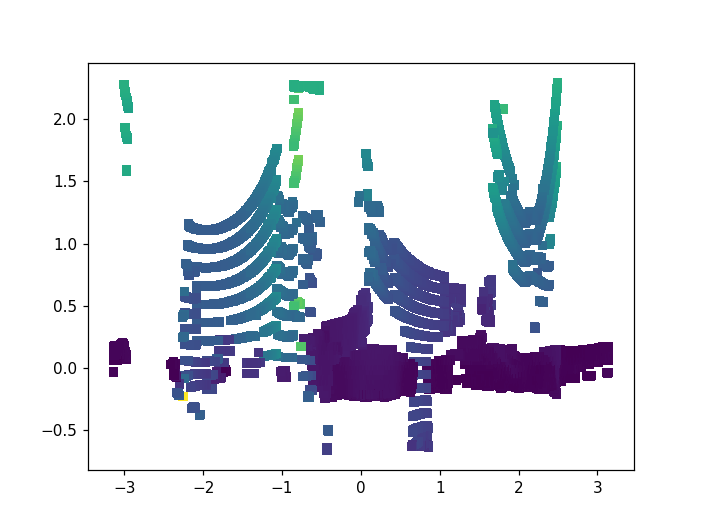

In [6]:
plt.figure()
plt.scatter(w, z, c=r, marker='s', edgecolor="none")

<IPython.core.display.Javascript object>


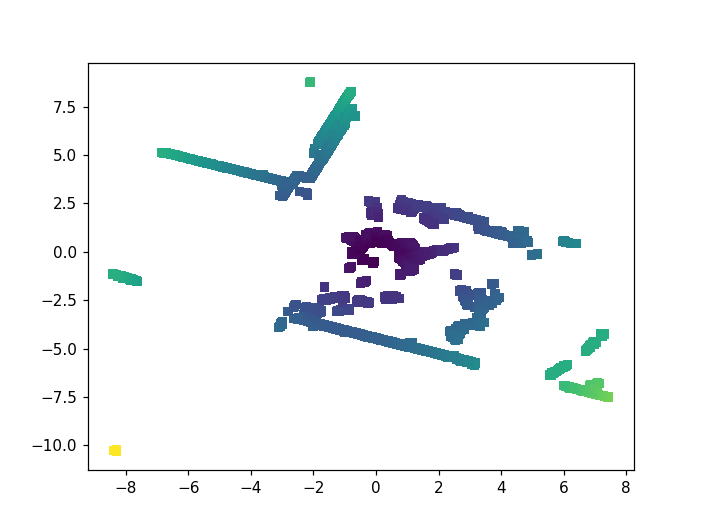

In [8]:
plt.figure()
plt.scatter(x,y, c=r, marker='s', edgecolor="none")

<IPython.core.display.Javascript object>


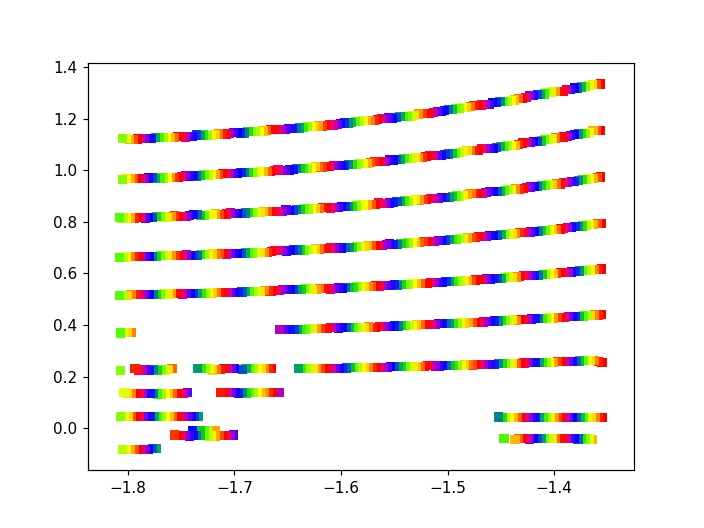

In [9]:
plt.figure()
plt.scatter(w[:1000],z[:1000], c=j[:1000], marker='s', edgecolor="none", cmap='prism')

In [ ]:
val = gridify(w,z,r, resolution=(200,100), value_approximation='min')[1]

In [ ]:
plt.figure()
plt.imshow(val)

## Animation

<IPython.core.display.Javascript object>


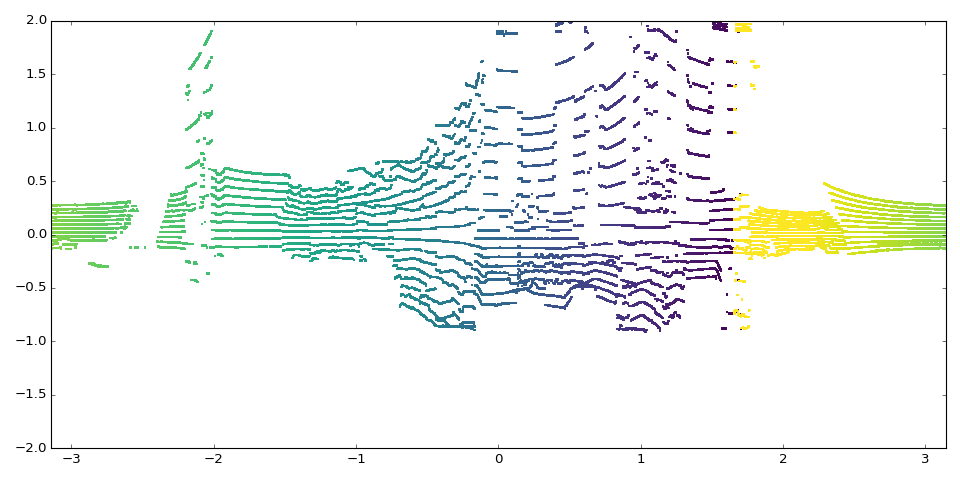

In [12]:
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation
FPS = 30
fig = plt.figure("Generating Animation", figsize=(12,6))
norm = plt.Normalize()
ax = plt.axes()
ax.set_xlim(-np.pi,np.pi)
ax.set_ylim(-2,2)
plt.tight_layout()
scat = ax.scatter([], [], c=[], marker='s', edgecolor="none", s=5)
def update(frame_number):
    points = frames[frame_number % len(frames)]
    x = points[:,0]
    y = points[:,1]
    z = points[:,2]
    w = np.arctan2(y, x)
    r = np.sqrt(x*x+y*y)
    j = np.arange(x.size)
    scat.set_offsets(np.array([w,z]).T)
    scat.set_facecolor(plt.cm.viridis(norm(j)))
try:
  anim = FuncAnimation(fig, update, frames=len(frames), interval=1000/FPS)
except KeyboardInterrupt:
  print("Ended.")

In [ ]:
rc('animation', html='html5')
anim

In [ ]:
anim.save('/tmp/LIDAR.mp4', fps=FPS, extra_args=['-vcodec', 'libx264'])

<IPython.core.display.Javascript object>


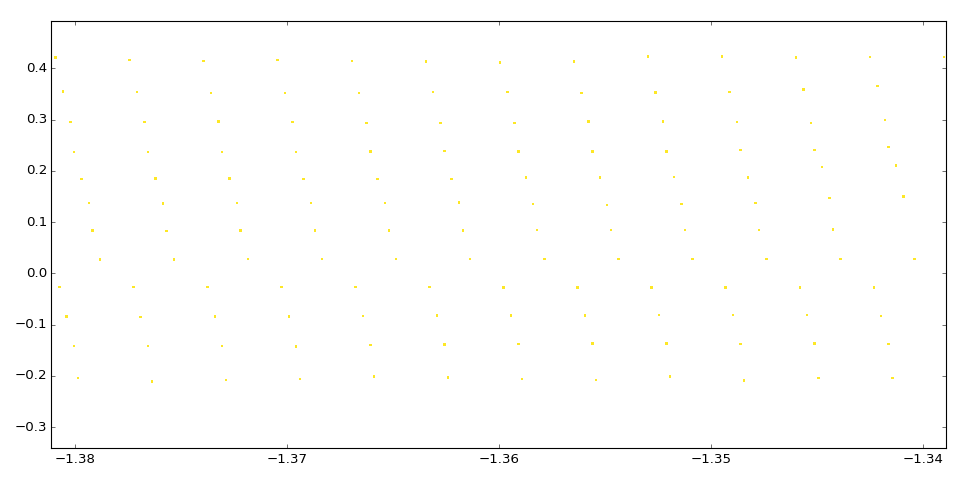

In [9]:
# Animating point order
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation
FPS = 60
MULT = 20
fig3 = plt.figure("Generating Animation 2", figsize=(12,6))
norm = plt.Normalize()
ax3 = plt.axes()
ax3.set_xlim(-np.pi,np.pi)
ax3.set_ylim(-2,2)
plt.tight_layout()
points = frames[0]
x = points[:,0]
y = points[:,1]
z = points[:,2]
w = np.arctan2(y, x)
r = np.sqrt(x*x+y*y)
j = np.arange(x.size)
scat3 = ax3.scatter([], [], c=[], marker='s', edgecolor="none", s=5, vmin=min(r), vmax=max(r))
def update3(frame_number):
    i = frame_number*MULT
    scat3.set_offsets(np.array([w[:i],z[:i]]).T)
    scat3.set_facecolor(plt.cm.viridis(r[:i]))
try:
  anim3 = FuncAnimation(fig3, update3, frames=len(j)/MULT, interval=1000/FPS)
except KeyboardInterrupt:
  print("Ended.")

## Animation Gridified

In [ ]:
grids = []
for points in frames:
    x = points[:,0]
    y = points[:,1]
    z = points[:,2]
    w = np.arctan2(y, x)
    r = np.sqrt(x*x+y*y)
    grids.append(gridify(w,z,r, resolution=(200,100), value_approximation='min')[1])

In [ ]:
from matplotlib import rc
from matplotlib.animation import FuncAnimation
#
FPS = 30
fig2 = plt.figure("PColorMesh Animation", figsize=(12,6))
ax2 = plt.axes()
plt.tight_layout()
im = ax2.imshow(grids[0])
def update2(frame_number):
    im.set_data(grids[frame_number % len(frames)])
    im.set_cmap(plt.get_cmap("viridis"))
try:
  anim2 = FuncAnimation(fig2, update2, frames=len(frames), interval=1000/FPS)
except KeyboardInterrupt:
  print("Ended.")

In [ ]:
anim2.save('/tmp/LIDAR_grid.mp4', fps=FPS, extra_args=['-vcodec', 'libx264'])